In [35]:
import numpy as np
import pandas as pd
import seaborn as sns
import plotly.express as px
from matplotlib import pyplot as plt
from sklearn.model_selection import cross_val_score

from sklearn import metrics
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

In [36]:
import numpy as np
import tensorflow as tf
import random

np.random.seed(42)
random.seed(42)
tf.random.set_seed(42)

In [37]:
customer_df = pd.read_csv('./Churn_Modelling.csv')

In [38]:
customer_df= customer_df.drop('RowNumber', axis=1)
customer_df= customer_df.drop('CustomerId', axis=1)
customer_df= customer_df.drop('Surname', axis=1)

In [39]:
customer_df.head()

,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [40]:
X = customer_df.drop('Exited', axis=1)
y = customer_df['Exited']

In [41]:
categorical_features = ['Geography', 'Gender']
# numeric_features = X.select_dtypes(include=['int64', 'float64']).columns
numeric_features=['CreditScore', 'Age', 'Tenure', 'Balance',
       'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']
print("Numeric Features are", numeric_features)
print("Categorical Features are", categorical_features)

Numeric Features are ['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard', 'IsActiveMember', 'EstimatedSalary']
Categorical Features are ['Geography', 'Gender']


In [42]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size = 0.2, random_state = 42)

In [43]:
from sklearn.preprocessing import StandardScaler

# Creating function for scaling
def Standard_Scaler (df, col_names):
    features = df[col_names]
    scaler = StandardScaler().fit(features.values)
    features = scaler.transform(features.values)
    df[col_names] = features
    
    return df

In [44]:
col_names = numeric_features
X_train = Standard_Scaler (X_train, col_names)
X_test = Standard_Scaler (X_test, col_names)

In [45]:
def one_hot_encode(df, col_names):
    """
    Perform one-hot encoding on specified categorical columns of a DataFrame.

    Parameters:
    df (pd.DataFrame): The input DataFrame containing the categorical columns.
    col_names (list of str): List of column names to one-hot encode.

    Returns:
    pd.DataFrame: The DataFrame with one-hot encoded columns.
    """
    # Perform one-hot encoding on the specified columns
    df_encoded = pd.get_dummies(df, columns=col_names, drop_first=True, dtype='float64')

    return df_encoded

In [46]:
col_names = categorical_features
X_train = one_hot_encode (X_train, col_names)
X_test = one_hot_encode (X_test, col_names)

In [47]:
X_train.columns

Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Geography_Germany',
       'Geography_Spain', 'Gender_Male'],
      dtype='object')

In [48]:
import numpy as np
import pandas as pd
from imblearn.over_sampling import SMOTE, RandomOverSampler
from imblearn.combine import SMOTETomek
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score, fbeta_score, accuracy_score
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.utils.class_weight import compute_class_weight


In [49]:
def build_fnn(input_shape):
    model = Sequential([
        Dense(128, activation='relu', input_shape=input_shape),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(32, activation='relu'),
        Dense(2, activation='softmax')  # For binary classification
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model


## SMOTE + Tomek Links

In [50]:
# Convert to numpy arrays
X_train_array = X_train.values
y_train_array = y_train.values

# Check the shapes and data types
print(X_train_array.shape, type(X_train_array))
print(y_train_array.shape, type(y_train_array))

(8000, 11) <class 'numpy.ndarray'>
(8000,) <class 'numpy.ndarray'>


In [51]:
# Apply SMOTE + Tomek Links
smote_tomek = SMOTETomek(random_state=42)
X_train_resampled_smote_tomek, y_train_resampled_smote_tomek = smote_tomek.fit_resample(X_train_array, y_train_array)

# Reshape and one-hot encode
X_train_resampled_smote_tomek = X_train_resampled_smote_tomek.reshape(X_train_resampled_smote_tomek.shape[0], X_train_resampled_smote_tomek.shape[1])
y_train_resampled_smote_tomek_categorical = to_categorical(y_train_resampled_smote_tomek)

# Assuming X_test is a pandas DataFrame
X_test_array = X_test.values  # Convert X_test to a numpy array

# Reshape X_test_array for FNN (since FNN expects data in (samples, features) format)
X_test_reshaped = X_test_array.reshape(X_test_array.shape[0], X_test_array.shape[1])



# Define and train the FNN model
fnn_model_smote_tomek = build_fnn((X_train_resampled_smote_tomek.shape[1],))
history_fnn_smote_tomek = fnn_model_smote_tomek.fit(
    X_train_resampled_smote_tomek, y_train_resampled_smote_tomek_categorical,
    epochs=50,
    validation_split=0.2,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)],
    batch_size=32,
    verbose=1
)




Epoch 1/50
316/316 [==============================] - 2s 3ms/step - loss: 0.5877 - accuracy: 0.6943 - val_loss: 0.6158 - val_accuracy: 0.7086
Epoch 2/50
316/316 [==============================] - 1s 3ms/step - loss: 0.5198 - accuracy: 0.7495 - val_loss: 0.5688 - val_accuracy: 0.7050
Epoch 3/50
316/316 [==============================] - 1s 3ms/step - loss: 0.4912 - accuracy: 0.7674 - val_loss: 0.5672 - val_accuracy: 0.7185
Epoch 4/50
316/316 [==============================] - 1s 3ms/step - loss: 0.4694 - accuracy: 0.7823 - val_loss: 0.5872 - val_accuracy: 0.6852
Epoch 5/50
316/316 [==============================] - 1s 3ms/step - loss: 0.4558 - accuracy: 0.7869 - val_loss: 0.6011 - val_accuracy: 0.6705
Epoch 6/50
316/316 [==============================] - 1s 3ms/step - loss: 0.4568 - accuracy: 0.7895 - val_loss: 0.5709 - val_accuracy: 0.6971
Epoch 7/50
316/316 [==============================] - 1s 3ms/step - loss: 0.4471 - accuracy: 0.7920 - val_loss: 0.6117 - val_accuracy: 0.6681
Epoch 

In [52]:
from sklearn.metrics import recall_score, precision_score, f1_score, fbeta_score, accuracy_score, roc_auc_score
# Evaluate the model
fnn_predictions_smote_tomek = fnn_model_smote_tomek.predict(X_test_array)
fnn_pred_labels_smote_tomek = np.argmax(fnn_predictions_smote_tomek, axis=1)

# Calculate metrics
fnn_recall_smote_tomek = recall_score(y_test, fnn_pred_labels_smote_tomek)
fnn_precision_smote_tomek = precision_score(y_test, fnn_pred_labels_smote_tomek)
fnn_f1_smote_tomek = f1_score(y_test, fnn_pred_labels_smote_tomek)
fnn_f2_smote_tomek = fbeta_score(y_test, fnn_pred_labels_smote_tomek, beta=2)
fnn_accuracy_smote_tomek = accuracy_score(y_test, fnn_pred_labels_smote_tomek)
fnn_roc_auc_smote_tomek = roc_auc_score(y_test, fnn_predictions_smote_tomek[:, 1])

# Create a DataFrame to store the scores
fnn_score_smote_tomek = pd.DataFrame(
    data=[(fnn_recall_smote_tomek, fnn_precision_smote_tomek, fnn_f1_smote_tomek, fnn_f2_smote_tomek, fnn_accuracy_smote_tomek,fnn_roc_auc_smote_tomek)],
    columns=['Recall', 'Precision', 'F1 Score', 'F2 Score', 'Accuracy', 'AUC-ROC']
)
fnn_score_smote_tomek.insert(0, 'Model', 'FNN with SMOTE + Tomek Links')

# Display the DataFrame
fnn_score_smote_tomek

63/63 [==============================] - 0s 3ms/step


,Model,Recall,Precision,F1 Score,F2 Score,Accuracy,AUC-ROC
0,FNN with SMOTE + Tomek Links,0.687961,0.552268,0.612691,0.655738,0.823,0.859451


## NO Under/Over Sampling

In [53]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import recall_score, precision_score, f1_score, fbeta_score, accuracy_score

# Assuming X_train and y_train are already defined

# Convert X_train and y_train to numpy arrays
X_train_array = X_train.values
y_train_array = y_train.values

# Convert y_train to one-hot encoding
y_train_categorical = to_categorical(y_train_array)

# Reshape X_train_array for FNN
X_train_reshaped = X_train_array.reshape(X_train_array.shape[0], X_train_array.shape[1])

# Convert X_test to numpy array
X_test_array = X_test.values
X_test_reshaped = X_test_array.reshape(X_test_array.shape[0], X_test_array.shape[1])

# Convert y_test to one-hot encoding
y_test_categorical = to_categorical(y_test)

# # Define and build the FNN model
# def build_fnn(input_shape):
#     model = Sequential([
#         Dense(128, activation='relu', input_shape=input_shape),
#         Dropout(0.5),
#         Dense(64, activation='relu'),
#         Dropout(0.5),
#         Dense(32, activation='relu'),
#         Dense(2, activation='softmax')  # For binary classification
#     ])
#     model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#     return model

# Build the model
fnn_model_no_sampling = build_fnn((X_train_reshaped.shape[1],))

# Train the model
history_fnn_no_sampling = fnn_model_no_sampling.fit(
    X_train_reshaped, y_train_categorical,
    epochs=50,
    validation_split=0.2,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)],
    batch_size=32,
    verbose=1
)




Epoch 1/50
200/200 [==============================] - 2s 3ms/step - loss: 0.4882 - accuracy: 0.7895 - val_loss: 0.4342 - val_accuracy: 0.8138
Epoch 2/50
200/200 [==============================] - 1s 3ms/step - loss: 0.4418 - accuracy: 0.8105 - val_loss: 0.4122 - val_accuracy: 0.8438
Epoch 3/50
200/200 [==============================] - 1s 3ms/step - loss: 0.4263 - accuracy: 0.8159 - val_loss: 0.3912 - val_accuracy: 0.8550
Epoch 4/50
200/200 [==============================] - 1s 3ms/step - loss: 0.4093 - accuracy: 0.8288 - val_loss: 0.3666 - val_accuracy: 0.8594
Epoch 5/50
200/200 [==============================] - 1s 3ms/step - loss: 0.3939 - accuracy: 0.8322 - val_loss: 0.3595 - val_accuracy: 0.8612
Epoch 6/50
200/200 [==============================] - 1s 5ms/step - loss: 0.3903 - accuracy: 0.8369 - val_loss: 0.3475 - val_accuracy: 0.8644
Epoch 7/50
200/200 [==============================] - 1s 5ms/step - loss: 0.3813 - accuracy: 0.8441 - val_loss: 0.3451 - val_accuracy: 0.8619
Epoch 

In [54]:
# Evaluate the model on the test set
fnn_predictions_no_sampling = fnn_model_no_sampling.predict(X_test_reshaped)
fnn_pred_labels_no_sampling = np.argmax(fnn_predictions_no_sampling, axis=1)

# Calculate metrics
fnn_recall_no_sampling = recall_score(y_test, fnn_pred_labels_no_sampling)
fnn_precision_no_sampling = precision_score(y_test, fnn_pred_labels_no_sampling)
fnn_f1_no_sampling = f1_score(y_test, fnn_pred_labels_no_sampling)
fnn_f2_no_sampling = fbeta_score(y_test, fnn_pred_labels_no_sampling, beta=2)
fnn_accuracy_no_sampling = accuracy_score(y_test, fnn_pred_labels_no_sampling)
fnn_roc_auc_no_sampling = roc_auc_score(y_test, fnn_predictions_no_sampling[:, 1])

# Create a DataFrame to store the scores
fnn_score_no_sampling = pd.DataFrame(
    data=[(fnn_recall_no_sampling, fnn_precision_no_sampling, fnn_f1_no_sampling, fnn_f2_no_sampling, fnn_accuracy_no_sampling,fnn_roc_auc_no_sampling)],
    columns=['Recall', 'Precision', 'F1 Score', 'F2 Score', 'Accuracy', 'AUC-ROC']
)
fnn_score_no_sampling.insert(0, 'Model', 'FNN with No Sampling')

# Display the DataFrame
fnn_score_no_sampling

63/63 [==============================] - 0s 1ms/step


,Model,Recall,Precision,F1 Score,F2 Score,Accuracy,AUC-ROC
0,FNN with No Sampling,0.425061,0.804651,0.55627,0.469343,0.862,0.86209


## Class Weights

In [55]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import recall_score, precision_score, f1_score, fbeta_score, accuracy_score

# Assuming X_train and y_train are already defined

# Convert X_train and y_train to numpy arrays
X_train_array = X_train.values
y_train_array = y_train.values

# Compute class weights
class_weights = compute_class_weight(class_weight='balanced', classes=np.unique(y_train_array), y=y_train_array)
class_weights_dict = dict(enumerate(class_weights))

# Convert y_train to one-hot encoding
y_train_categorical = to_categorical(y_train_array)

# Reshape X_train_array for FNN
X_train_reshaped = X_train_array.reshape(X_train_array.shape[0], X_train_array.shape[1])

# Convert X_test to numpy array
X_test_array = X_test.values
X_test_reshaped = X_test_array.reshape(X_test_array.shape[0], X_test_array.shape[1])

# Convert y_test to one-hot encoding
y_test_categorical = to_categorical(y_test)

# # Define and build the FNN model
# def build_fnn(input_shape):
#     model = Sequential([
#         Dense(128, activation='relu', input_shape=input_shape),
#         Dropout(0.5),
#         Dense(64, activation='relu'),
#         Dropout(0.5),
#         Dense(32, activation='relu'),
#         Dense(2, activation='softmax')  # For binary classification
#     ])
#     model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#     return model

# Build the model
fnn_model_class_weights = build_fnn((X_train_reshaped.shape[1],))

# Train the model with class weights
history_fnn_class_weights = fnn_model_class_weights.fit(
    X_train_reshaped, y_train_categorical,
    epochs=50,
    validation_split=0.2,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)],
    batch_size=32,
    verbose=1,
    class_weight=class_weights_dict  # Pass class weights here
)



Epoch 1/50
200/200 [==============================] - 1s 3ms/step - loss: 0.6427 - accuracy: 0.5983 - val_loss: 0.5587 - val_accuracy: 0.7212
Epoch 2/50
200/200 [==============================] - 0s 2ms/step - loss: 0.5850 - accuracy: 0.6941 - val_loss: 0.5284 - val_accuracy: 0.7269
Epoch 3/50
200/200 [==============================] - 1s 4ms/step - loss: 0.5655 - accuracy: 0.7209 - val_loss: 0.4983 - val_accuracy: 0.7644
Epoch 4/50
200/200 [==============================] - 1s 5ms/step - loss: 0.5429 - accuracy: 0.7247 - val_loss: 0.4687 - val_accuracy: 0.7750
Epoch 5/50
200/200 [==============================] - 1s 5ms/step - loss: 0.5286 - accuracy: 0.7383 - val_loss: 0.4592 - val_accuracy: 0.7775
Epoch 6/50
200/200 [==============================] - 1s 5ms/step - loss: 0.5166 - accuracy: 0.7605 - val_loss: 0.4471 - val_accuracy: 0.7844
Epoch 7/50
200/200 [==============================] - 1s 3ms/step - loss: 0.5032 - accuracy: 0.7623 - val_loss: 0.4530 - val_accuracy: 0.7812
Epoch 

In [56]:
# Evaluate the model on the test set
fnn_predictions_class_weights = fnn_model_class_weights.predict(X_test_reshaped)
fnn_pred_labels_class_weights = np.argmax(fnn_predictions_class_weights, axis=1)

# Calculate metrics
fnn_recall_class_weights = recall_score(y_test, fnn_pred_labels_class_weights)
fnn_precision_class_weights = precision_score(y_test, fnn_pred_labels_class_weights)
fnn_f1_class_weights = f1_score(y_test, fnn_pred_labels_class_weights)
fnn_f2_class_weights = fbeta_score(y_test, fnn_pred_labels_class_weights, beta=2)
fnn_accuracy_class_weights = accuracy_score(y_test, fnn_pred_labels_class_weights)
fnn_roc_auc_class_weights = roc_auc_score(y_test, fnn_predictions_class_weights[:, 1])

# Create a DataFrame to store the scores
fnn_score_class_weights = pd.DataFrame(
    data=[(fnn_recall_class_weights, fnn_precision_class_weights, fnn_f1_class_weights, fnn_f2_class_weights, fnn_accuracy_class_weights,fnn_roc_auc_class_weights)],
    columns=['Recall', 'Precision', 'F1 Score', 'F2 Score', 'Accuracy', 'AUC-ROC']
)
fnn_score_class_weights.insert(0, 'Model', 'FNN with Class Weights')

# Display the DataFrame
fnn_score_class_weights


63/63 [==============================] - 0s 2ms/step


,Model,Recall,Precision,F1 Score,F2 Score,Accuracy,AUC-ROC
0,FNN with Class Weights,0.744472,0.506689,0.602985,0.680593,0.8005,0.862008


## Random Oversampling

In [57]:
from imblearn.over_sampling import RandomOverSampler
from tensorflow.keras.utils import to_categorical

# Convert X_train and y_train to numpy arrays if they are not already
X_train_array = X_train.values
y_train_array = y_train.values

# Apply Random Oversampling
ros = RandomOverSampler(random_state=42)
X_train_resampled, y_train_resampled = ros.fit_resample(X_train_array, y_train_array)

# Reshape X_train_resampled for FNN
X_train_resampled_reshaped = X_train_resampled.reshape(X_train_resampled.shape[0], X_train_resampled.shape[1])

# Convert y_train_resampled to one-hot encoding
y_train_resampled_categorical = to_categorical(y_train_resampled)

# Reshape X_test for FNN
X_test_array = X_test.values
X_test_reshaped = X_test_array.reshape(X_test_array.shape[0], X_test_array.shape[1])

# Convert y_test to one-hot encoding
y_test_categorical = to_categorical(y_test)


In [58]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# def build_fnn(input_shape):
#     model = Sequential([
#         Dense(128, activation='relu', input_shape=input_shape),
#         Dropout(0.5),
#         Dense(64, activation='relu'),
#         Dropout(0.5),
#         Dense(32, activation='relu'),
#         Dense(2, activation='softmax')  # For binary classification
#     ])
#     model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#     return model

# Build the model
fnn_model_random_oversampling = build_fnn((X_train_resampled_reshaped.shape[1],))

# Train the model with random oversampling data
history_fnn_random_oversampling = fnn_model_random_oversampling.fit(
    X_train_resampled_reshaped, y_train_resampled_categorical,
    epochs=50,
    validation_split=0.2,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)],
    batch_size=32,
    verbose=1
)


Epoch 1/50
319/319 [==============================] - 2s 4ms/step - loss: 0.6028 - accuracy: 0.6762 - val_loss: 0.6074 - val_accuracy: 0.6970
Epoch 2/50
319/319 [==============================] - 2s 5ms/step - loss: 0.5427 - accuracy: 0.7300 - val_loss: 0.6766 - val_accuracy: 0.6016
Epoch 3/50
319/319 [==============================] - 1s 4ms/step - loss: 0.5107 - accuracy: 0.7536 - val_loss: 0.6031 - val_accuracy: 0.6456
Epoch 4/50
319/319 [==============================] - 1s 3ms/step - loss: 0.4890 - accuracy: 0.7674 - val_loss: 0.6866 - val_accuracy: 0.6119
Epoch 5/50
319/319 [==============================] - 1s 3ms/step - loss: 0.4787 - accuracy: 0.7779 - val_loss: 0.6385 - val_accuracy: 0.6232
Epoch 6/50
319/319 [==============================] - 1s 3ms/step - loss: 0.4719 - accuracy: 0.7766 - val_loss: 0.5438 - val_accuracy: 0.6644
Epoch 7/50
319/319 [==============================] - 1s 4ms/step - loss: 0.4699 - accuracy: 0.7799 - val_loss: 0.6122 - val_accuracy: 0.6452
Epoch 

In [59]:
import numpy as np
import pandas as pd
from sklearn.metrics import recall_score, precision_score, f1_score, fbeta_score, accuracy_score, confusion_matrix

# Evaluate the model on the test set
fnn_predictions_random_oversampling = fnn_model_random_oversampling.predict(X_test_reshaped)
fnn_pred_labels_random_oversampling = np.argmax(fnn_predictions_random_oversampling, axis=1)

# Calculate metrics
fnn_recall_random_oversampling = recall_score(y_test, fnn_pred_labels_random_oversampling)
fnn_precision_random_oversampling = precision_score(y_test, fnn_pred_labels_random_oversampling)
fnn_f1_random_oversampling = f1_score(y_test, fnn_pred_labels_random_oversampling)
fnn_f2_random_oversampling = fbeta_score(y_test, fnn_pred_labels_random_oversampling, beta=2)
fnn_accuracy_random_oversampling = accuracy_score(y_test, fnn_pred_labels_random_oversampling)
fnn_roc_auc_random_oversampling = roc_auc_score(y_test, fnn_predictions_random_oversampling[:, 1])

# Create a DataFrame to store the scores
fnn_score_random_oversampling = pd.DataFrame(
    data=[(fnn_recall_random_oversampling, fnn_precision_random_oversampling, fnn_f1_random_oversampling, fnn_f2_random_oversampling, fnn_accuracy_random_oversampling,fnn_roc_auc_random_oversampling)],
    columns=['Recall', 'Precision', 'F1 Score', 'F2 Score', 'Accuracy', 'AUC-ROC']
)
fnn_score_random_oversampling.insert(0, 'Model', 'FNN with Random Oversampling')

# Display the DataFrame
fnn_score_random_oversampling


63/63 [==============================] - 0s 1ms/step


,Model,Recall,Precision,F1 Score,F2 Score,Accuracy,AUC-ROC
0,FNN with Random Oversampling,0.614251,0.651042,0.632111,0.621272,0.8545,0.864092


## SMOTE oversampling

In [60]:
from imblearn.over_sampling import SMOTE
from tensorflow.keras.utils import to_categorical

# Convert X_train and y_train to numpy arrays if they are not already
X_train_array = X_train.values
y_train_array = y_train.values

# Apply SMOTE Oversampling
smote = SMOTE(random_state=42)
X_train_resampled_smote, y_train_resampled_smote = smote.fit_resample(X_train_array, y_train_array)

# Reshape X_train_resampled_smote for FNN
X_train_resampled_smote_reshaped = X_train_resampled_smote.reshape(X_train_resampled_smote.shape[0], X_train_resampled_smote.shape[1])

# Convert y_train_resampled_smote to one-hot encoding
y_train_resampled_smote_categorical = to_categorical(y_train_resampled_smote)

# Reshape X_test for FNN
X_test_array = X_test.values
X_test_reshaped = X_test_array.reshape(X_test_array.shape[0], X_test_array.shape[1])

# Convert y_test to one-hot encoding
y_test_categorical = to_categorical(y_test)


In [61]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# def build_fnn(input_shape):
#     model = Sequential([
#         Dense(128, activation='relu', input_shape=input_shape),
#         Dropout(0.5),
#         Dense(64, activation='relu'),
#         Dropout(0.5),
#         Dense(32, activation='relu'),
#         Dense(2, activation='softmax')  # For binary classification
#     ])
#     model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#     return model

# Build the model
fnn_model_smote = build_fnn((X_train_resampled_smote_reshaped.shape[1],))

# Train the model with SMOTE data
history_fnn_smote = fnn_model_smote.fit(
    X_train_resampled_smote_reshaped, y_train_resampled_smote_categorical,
    epochs=50,
    validation_split=0.2,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)],
    batch_size=32,
    verbose=1
)


Epoch 1/50
319/319 [==============================] - 3s 6ms/step - loss: 0.5948 - accuracy: 0.6878 - val_loss: 0.5658 - val_accuracy: 0.7135
Epoch 2/50
319/319 [==============================] - 2s 5ms/step - loss: 0.5262 - accuracy: 0.7413 - val_loss: 0.6280 - val_accuracy: 0.6228
Epoch 3/50
319/319 [==============================] - 1s 3ms/step - loss: 0.4901 - accuracy: 0.7670 - val_loss: 0.5830 - val_accuracy: 0.6617
Epoch 4/50
319/319 [==============================] - 1s 3ms/step - loss: 0.4710 - accuracy: 0.7750 - val_loss: 0.6196 - val_accuracy: 0.6448
Epoch 5/50
319/319 [==============================] - 1s 3ms/step - loss: 0.4688 - accuracy: 0.7819 - val_loss: 0.6241 - val_accuracy: 0.6115
Epoch 6/50
319/319 [==============================] - 1s 3ms/step - loss: 0.4623 - accuracy: 0.7828 - val_loss: 0.5705 - val_accuracy: 0.6586


In [62]:

import numpy as np
from sklearn.metrics import recall_score, precision_score, f1_score, fbeta_score, accuracy_score, roc_auc_score, confusion_matrix
import pandas as pd

# Make predictions on the test set
fnn_predictions_smote = fnn_model_smote.predict(X_test_reshaped)

# Convert predicted probabilities to class labels
fnn_pred_labels_smote = np.argmax(fnn_predictions_smote, axis=1)

# Calculate the evaluation metrics
fnn_recall_smote = recall_score(y_test, fnn_pred_labels_smote)
fnn_precision_smote = precision_score(y_test, fnn_pred_labels_smote)
fnn_f1_smote = f1_score(y_test, fnn_pred_labels_smote)
fnn_f2_smote = fbeta_score(y_test, fnn_pred_labels_smote, beta=2)
fnn_accuracy_smote = accuracy_score(y_test, fnn_pred_labels_smote)
fnn_roc_auc_smote = roc_auc_score(y_test, fnn_predictions_smote[:, 1])

# Create a confusion matrix
cm_smote = confusion_matrix(y_test, fnn_pred_labels_smote)

# Print the confusion matrix
print("Confusion Matrix:\n", cm_smote)

# Create a DataFrame to store the scores
fnn_score_smote = pd.DataFrame(
    data=[(fnn_recall_smote, fnn_precision_smote, fnn_f1_smote, fnn_f2_smote, fnn_accuracy_smote, fnn_roc_auc_smote)],
    columns=['Recall', 'Precision', 'F1 Score', 'F2 Score', 'Accuracy', 'AUC-ROC']
)
fnn_score_smote.insert(0, 'Model', 'FNN with SMOTE')

# Display the DataFrame with the metrics
fnn_score_smote


63/63 [==============================] - 0s 3ms/step
Confusion Matrix:
 [[1418  175]
 [ 151  256]]


,Model,Recall,Precision,F1 Score,F2 Score,Accuracy,AUC-ROC
0,FNN with SMOTE,0.628993,0.593968,0.610979,0.621661,0.837,0.853578


## SMOTEENN

In [63]:
import numpy as np
import pandas as pd
from imblearn.combine import SMOTEENN
from sklearn.metrics import recall_score, precision_score, f1_score, fbeta_score, accuracy_score, roc_auc_score, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

# Assuming X_train and y_train are your original training features and labels
X_train_array = X_train.values  # Convert to numpy array if it's a DataFrame
y_train_array = y_train.values  # Convert to numpy array if it's a Series

# Apply SMOTEENN (SMOTE + Edited Nearest Neighbors)
smoteenn = SMOTEENN(random_state=42)
X_train_resampled_smoteenn, y_train_resampled_smoteenn = smoteenn.fit_resample(X_train_array, y_train_array)

# Reshape X_train_resampled_smoteenn for FNN
X_train_resampled_smoteenn_reshaped = X_train_resampled_smoteenn.reshape(X_train_resampled_smoteenn.shape[0], X_train_resampled_smoteenn.shape[1])

# Convert y_train_resampled_smoteenn to one-hot encoding
y_train_resampled_smoteenn_categorical = to_categorical(y_train_resampled_smoteenn)

# Reshape X_test for FNN
X_test_array = X_test.values
X_test_reshaped = X_test_array.reshape(X_test_array.shape[0], X_test_array.shape[1])

# Convert y_test to one-hot encoding
y_test_categorical = to_categorical(y_test)

# Define the FNN model
def build_fnn(input_shape):
    model = Sequential([
        Dense(128, activation='relu', input_shape=input_shape),
        Dropout(0.5),
        Dense(64, activation='relu'),
        Dropout(0.5),
        Dense(32, activation='relu'),
        Dense(2, activation='softmax')  # For binary classification
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Build the FNN model
fnn_model_smoteenn = build_fnn((X_train_resampled_smoteenn_reshaped.shape[1],))

# Train the model with SMOTEENN data
history_fnn_smoteenn = fnn_model_smoteenn.fit(
    X_train_resampled_smoteenn_reshaped, y_train_resampled_smoteenn_categorical,
    epochs=50,
    validation_split=0.2,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)],
    batch_size=32,
    verbose=1
)

# Make predictions on the test set
fnn_predictions_smoteenn = fnn_model_smoteenn.predict(X_test_reshaped)

# Convert predicted probabilities to class labels
fnn_pred_labels_smoteenn = np.argmax(fnn_predictions_smoteenn, axis=1)

# Calculate the evaluation metrics
fnn_recall_smoteenn = recall_score(y_test, fnn_pred_labels_smoteenn)
fnn_precision_smoteenn = precision_score(y_test, fnn_pred_labels_smoteenn)
fnn_f1_smoteenn = f1_score(y_test, fnn_pred_labels_smoteenn)
fnn_f2_smoteenn = fbeta_score(y_test, fnn_pred_labels_smoteenn, beta=2)
fnn_accuracy_smoteenn = accuracy_score(y_test, fnn_pred_labels_smoteenn)
fnn_roc_auc_smoteenn = roc_auc_score(y_test, fnn_predictions_smoteenn[:, 1])

# Create a confusion matrix
cm_smoteenn = confusion_matrix(y_test, fnn_pred_labels_smoteenn)

# Print the confusion matrix
print("Confusion Matrix:\n", cm_smoteenn)

# Create a DataFrame to store the scores
fnn_score_smoteenn = pd.DataFrame(
    data=[(fnn_recall_smoteenn, fnn_precision_smoteenn, fnn_f1_smoteenn, fnn_f2_smoteenn, fnn_accuracy_smoteenn, fnn_roc_auc_smoteenn)],
    columns=['Recall', 'Precision', 'F1 Score', 'F2 Score', 'Accuracy', 'AUC-ROC']
)
fnn_score_smoteenn.insert(0, 'Model', 'FNN with SMOTEENN')

# Display the DataFrame with the metrics
fnn_score_smoteenn


Epoch 1/50
246/246 [==============================] - 2s 3ms/step - loss: 0.5424 - accuracy: 0.7255 - val_loss: 0.4136 - val_accuracy: 0.8210
Epoch 2/50
246/246 [==============================] - 1s 3ms/step - loss: 0.4199 - accuracy: 0.8178 - val_loss: 0.4205 - val_accuracy: 0.8159
Epoch 3/50
246/246 [==============================] - 1s 3ms/step - loss: 0.3667 - accuracy: 0.8444 - val_loss: 0.3925 - val_accuracy: 0.8271
Epoch 4/50
246/246 [==============================] - 1s 3ms/step - loss: 0.3491 - accuracy: 0.8538 - val_loss: 0.3297 - val_accuracy: 0.8542
Epoch 5/50
246/246 [==============================] - 1s 4ms/step - loss: 0.3222 - accuracy: 0.8661 - val_loss: 0.3161 - val_accuracy: 0.8644
Epoch 6/50
246/246 [==============================] - 1s 5ms/step - loss: 0.3202 - accuracy: 0.8688 - val_loss: 0.3276 - val_accuracy: 0.8552
Epoch 7/50
246/246 [==============================] - 1s 5ms/step - loss: 0.3131 - accuracy: 0.8703 - val_loss: 0.3177 - val_accuracy: 0.8751
Epoch 

,Model,Recall,Precision,F1 Score,F2 Score,Accuracy,AUC-ROC
0,FNN with SMOTEENN,0.769042,0.475684,0.587793,0.684602,0.7805,0.859092


In [64]:
predictions = pd.concat(
    [fnn_score_no_sampling, fnn_score_random_oversampling, fnn_score_smote, fnn_score_smote_tomek, fnn_score_class_weights,fnn_score_smoteenn],
    ignore_index=True,
    sort=False
)

# Sort the concatenated DataFrame by 'Recall' in descending order
predictions_sorted = predictions.sort_values(by=['Recall'], ascending=False)

# Display the sorted DataFrame
predictions_sorted

,Model,Recall,Precision,F1 Score,F2 Score,Accuracy,AUC-ROC
5,FNN with SMOTEENN,0.769042,0.475684,0.587793,0.684602,0.7805,0.859092
4,FNN with Class Weights,0.744472,0.506689,0.602985,0.680593,0.8005,0.862008
3,FNN with SMOTE + Tomek Links,0.687961,0.552268,0.612691,0.655738,0.8230,0.859451
2,FNN with SMOTE,0.628993,0.593968,0.610979,0.621661,0.8370,0.853578
1,FNN with Random Oversampling,0.614251,0.651042,0.632111,0.621272,0.8545,0.864092
0,FNN with No Sampling,0.425061,0.804651,0.556270,0.469343,0.8620,0.862090


## Hyperparameter Tuning

In [1]:
import numpy as np
import pandas as pd
from imblearn.combine import SMOTEENN
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import recall_score, precision_score, f1_score, fbeta_score, accuracy_score, roc_auc_score, confusion_matrix
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from keras_tuner import RandomSearch
from tensorflow.keras.callbacks import EarlyStopping

# Load the dataset
customer_df = pd.read_csv('./Churn_Modelling.csv')

# Data Preprocessing
# Drop columns that are not features or target (e.g., 'RowNumber', 'CustomerId', 'Surname')
customer_df = customer_df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)

# Convert categorical variables into dummy/indicator variables
customer_df = pd.get_dummies(customer_df)

# Split the dataset into features and target variable
X = customer_df.drop('Exited', axis=1)
y = customer_df['Exited']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert y_train and y_test to numpy arrays
X_train_array = X_train
y_train_array = y_train.values
X_test_array = X_test
y_test_array = y_test.values

# Apply SMOTE + ENN (SMOTEENN) for oversampling
smoteenn = SMOTEENN(random_state=42)
X_train_resampled_smoteenn, y_train_resampled_smoteenn = smoteenn.fit_resample(X_train_array, y_train_array)

# Convert y_train_resampled_smoteenn to one-hot encoding
y_train_resampled_smoteenn_categorical = to_categorical(y_train_resampled_smoteenn)
y_test_categorical = to_categorical(y_test_array)

# Define the function to build the model with hyperparameters
def build_fnn(hp):
    model = Sequential()
    model.add(Dense(units=hp.Int('units_1', min_value=128, max_value=256, step=32), activation='relu', input_shape=(X_train_resampled_smoteenn.shape[1],)))
    model.add(Dropout(rate=hp.Float('dropout_1', min_value=0.3, max_value=0.6, step=0.1)))
    model.add(Dense(units=hp.Int('units_2', min_value=64, max_value=128, step=16), activation='relu'))
    model.add(Dropout(rate=hp.Float('dropout_2', min_value=0.3, max_value=0.6, step=0.1)))
    model.add(Dense(units=hp.Int('units_3', min_value=32, max_value=64, step=8), activation='relu'))
    model.add(Dense(2, activation='softmax'))  # For binary classification
    model.compile(
        optimizer=hp.Choice('optimizer', ['adam']),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Create a hyperparameter tuner instance
tuner = RandomSearch(
    build_fnn,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=1,
    directory='my_dir',
    project_name='fnn_tuning'
)

# Perform hyperparameter search
tuner.search(
    X_train_resampled_smoteenn,
    y_train_resampled_smoteenn_categorical,
    epochs=50,
    validation_split=0.2,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)],
    batch_size=32
)

# Retrieve the best model
best_model = tuner.get_best_models(num_models=1)[0]

# Train the best model
history_fnn_smoteenn = best_model.fit(
    X_train_resampled_smoteenn, y_train_resampled_smoteenn_categorical,
    epochs=50,
    validation_split=0.2,
    callbacks=[EarlyStopping(monitor='val_loss', patience=5)],
    batch_size=32,
    verbose=1
)

# Make predictions on the test set
fnn_predictions_smoteenn = best_model.predict(X_test_array)

# Convert predicted probabilities to class labels
fnn_pred_labels_smoteenn = np.argmax(fnn_predictions_smoteenn, axis=1)

# Calculate the evaluation metrics
fnn_recall_smoteenn = recall_score(y_test_array, fnn_pred_labels_smoteenn)
fnn_precision_smoteenn = precision_score(y_test_array, fnn_pred_labels_smoteenn)
fnn_f1_smoteenn = f1_score(y_test_array, fnn_pred_labels_smoteenn)
fnn_f2_smoteenn = fbeta_score(y_test_array, fnn_pred_labels_smoteenn, beta=2)
fnn_accuracy_smoteenn = accuracy_score(y_test_array, fnn_pred_labels_smoteenn)
fnn_roc_auc_smoteenn = roc_auc_score(y_test_array, fnn_predictions_smoteenn[:, 1])

# Create a confusion matrix
cm_smoteenn = confusion_matrix(y_test_array, fnn_pred_labels_smoteenn)

# Print the confusion matrix
print("Confusion Matrix:\n", cm_smoteenn)

# Create a DataFrame to store the scores
fnn_score_smoteenn = pd.DataFrame(
    data=[(fnn_recall_smoteenn, fnn_precision_smoteenn, fnn_f1_smoteenn, fnn_f2_smoteenn, fnn_accuracy_smoteenn, fnn_roc_auc_smoteenn)],
    columns=['Recall', 'Precision', 'F1 Score', 'F2 Score', 'Accuracy', 'AUC-ROC']
)
fnn_score_smoteenn.insert(0, 'Model', 'FNN with SMOTEENN after hyperparameter tuning')

# Display the DataFrame with the metrics
print(fnn_score_smoteenn)



Reloading Tuner from my_dir\fnn_tuning\tuner0.json


Epoch 1/50


238/238 [==============================] - 2s 4ms/step - loss: 0.1489 - accuracy: 0.9385 - val_loss: 0.1073 - val_accuracy: 0.9637
Epoch 2/50
238/238 [==============================] - 1s 3ms/step - loss: 0.1568 - accuracy: 0.9341 - val_loss: 0.1293 - val_accuracy: 0.9580
Epoch 3/50
238/238 [==============================] - 1s 3ms/step - loss: 0.1470 - accuracy: 0.9378 - val_loss: 0.1255 - val_accuracy: 0.9580
Epoch 4/50
238/238 [==============================] - 1s 3ms/step - loss: 0.1492 - accuracy: 0.9399 - val_loss: 0.1327 - val_accuracy: 0.9538
Epoch 5/50
238/238 [==============================] - 1s 3ms/step - loss: 0.1383 - accuracy: 0.9452 - val_loss: 0.1042 - val_accuracy: 0.9606
Epoch 6/50
238/238 [==============================] - 1s 3ms/step - loss: 0.1469 - accuracy: 0.9410 - val_loss: 0.1155 - val_accuracy: 0.9574
Epoch 7/50
238/238 [==============================] - 1s 3ms/step - loss: 0.1548 - accuracy:

In [7]:
fnn_score_smoteenn

NameError: name 'fnn_score_smoteenn' is not defined

In [8]:
fnn_score_smoteenn['Model']="FNN with SMOTEENN after hyperparameter Tuning"

In [2]:
fnn_score_smoteenn

,Model,Recall,Precision,F1 Score,F2 Score,Accuracy,AUC-ROC
0,FNN with SMOTEENN after hyperparameter tuning,0.717557,0.462295,0.562313,0.646196,0.7805,0.838853


Trial 180 Complete [00h 00m 54s]
val_loss: 0.2606842815876007

Best val_loss So Far: 0.03840580955147743
Total elapsed time: 00h 35m 00s
Epoch 1/50
238/238 [==============================] - 3s 7ms/step - loss: 0.0659 - accuracy: 0.9752 - val_loss: 0.0726 - val_accuracy: 0.9732
Epoch 2/50
238/238 [==============================] - 1s 6ms/step - loss: 0.0562 - accuracy: 0.9791 - val_loss: 0.0428 - val_accuracy: 0.9869
Epoch 3/50
238/238 [==============================] - 1s 3ms/step - loss: 0.0616 - accuracy: 0.9759 - val_loss: 0.0641 - val_accuracy: 0.9779
Epoch 4/50
238/238 [==============================] - 1s 3ms/step - loss: 0.0653 - accuracy: 0.9746 - val_loss: 0.0522 - val_accuracy: 0.9821
Epoch 5/50
238/238 [==============================] - 1s 3ms/step - loss: 0.0562 - accuracy: 0.9803 - val_loss: 0.0647 - val_accuracy: 0.9779
Epoch 6/50
238/238 [==============================] - 1s 5ms/step - loss: 0.0579 - accuracy: 0.9767 - val_loss: 0.0570 - val_accuracy: 0.9806
Epoch 7/50


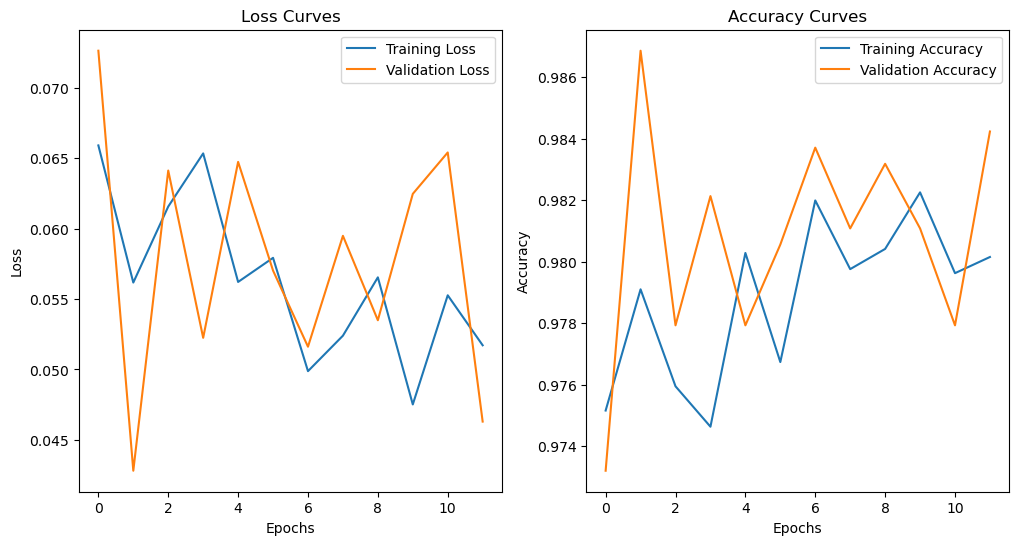

63/63 [==============================] - 0s 4ms/step
Confusion Matrix:
 [[1211  396]
 [ 114  279]]
                                           Model    Recall  Precision  \
0  FNN with SMOTEENN after hyperparameter tuning  0.709924   0.413333   

   F1 Score  F2 Score  Accuracy   AUC-ROC  
0  0.522472  0.620828     0.745  0.823238  


In [3]:
import numpy as np
import pandas as pd
from imblearn.combine import SMOTEENN
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (recall_score, precision_score, f1_score, fbeta_score, 
                             accuracy_score, roc_auc_score, confusion_matrix)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.utils import to_categorical
from keras_tuner import Hyperband
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import os
import shutil

# Load and preprocess the dataset
customer_df = pd.read_csv('./Churn_Modelling.csv')
customer_df = customer_df.drop(['RowNumber', 'CustomerId', 'Surname'], axis=1)
customer_df = pd.get_dummies(customer_df)

# Split data into features and target variable
X = customer_df.drop('Exited', axis=1)
y = customer_df['Exited']

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize the features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Apply SMOTE + ENN for oversampling
smoteenn = SMOTEENN(random_state=42)
X_train_resampled, y_train_resampled = smoteenn.fit_resample(X_train, y_train)

# Convert labels to one-hot encoding
y_train_resampled_categorical = to_categorical(y_train_resampled)
y_test_categorical = to_categorical(y_test)

# Define the function to build the model with hyperparameters
def build_fnn(hp):
    model = Sequential([
        Dense(units=hp.Int('units_1', min_value=128, max_value=256, step=32), activation='relu', input_shape=(X_train_resampled.shape[1],)),
        Dropout(rate=hp.Float('dropout_1', min_value=0.2, max_value=0.8, step=0.2)),
        Dense(units=hp.Int('units_2', min_value=64, max_value=128, step=16), activation='relu'),
        Dropout(rate=hp.Float('dropout_2', min_value=0.2, max_value=0.8, step=0.2)),
        Dense(units=hp.Int('units_3', min_value=32, max_value=64, step=8), activation='relu'),
        Dense(2, activation='softmax')
    ])
    model.compile(
        optimizer=hp.Choice('optimizer', ['adam', 'sgd']),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    return model

# Ensure the project directory is clean or use a new one
project_dir = 'new_dir'
project_name = 'fnn_tuning'
full_path = os.path.join(project_dir, project_name)

if os.path.exists(full_path):
    shutil.rmtree(full_path)

# Create and run the hyperparameter tuner
tuner = Hyperband(
    build_fnn,
    objective='val_loss',
    max_epochs=50,
    hyperband_iterations=2,
    directory=project_dir,
    project_name=project_name
)

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

tuner.search(
    X_train_resampled, 
    y_train_resampled_categorical,
    epochs=50,
    validation_split=0.2,
    callbacks=[early_stopping],
    batch_size=32
)

# Retrieve the best model and train it
best_model = tuner.get_best_models(num_models=1)[0]

history_fnn = best_model.fit(
    X_train_resampled, 
    y_train_resampled_categorical,
    epochs=50,
    validation_split=0.2,
    callbacks=[early_stopping],
    batch_size=32,
    verbose=1
)

# Plot training history
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history_fnn.history['loss'], label='Training Loss')
plt.plot(history_fnn.history['val_loss'], label='Validation Loss')
plt.title('Loss Curves')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history_fnn.history['accuracy'], label='Training Accuracy')
plt.plot(history_fnn.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy Curves')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

# Make predictions on the test set
fnn_predictions = best_model.predict(X_test)
fnn_pred_labels = np.argmax(fnn_predictions, axis=1)

# Calculate evaluation metrics
fnn_recall = recall_score(y_test, fnn_pred_labels)
fnn_precision = precision_score(y_test, fnn_pred_labels)
fnn_f1 = f1_score(y_test, fnn_pred_labels)
fnn_f2 = fbeta_score(y_test, fnn_pred_labels, beta=2)
fnn_accuracy = accuracy_score(y_test, fnn_pred_labels)
fnn_roc_auc = roc_auc_score(y_test, fnn_predictions[:, 1])

# Create and display confusion matrix
cm = confusion_matrix(y_test, fnn_pred_labels)
print("Confusion Matrix:\n", cm)

# Store and display the evaluation metrics
fnn_score_df = pd.DataFrame({
    'Model': ['FNN with SMOTEENN after hyperparameter tuning'],
    'Recall': [fnn_recall],
    'Precision': [fnn_precision],
    'F1 Score': [fnn_f1],
    'F2 Score': [fnn_f2],
    'Accuracy': [fnn_accuracy],
    'AUC-ROC': [fnn_roc_auc]
})

print(fnn_score_df)


In [4]:
fnn_score_df


,Model,Recall,Precision,F1 Score,F2 Score,Accuracy,AUC-ROC
0,FNN with SMOTEENN after hyperparameter tuning,0.709924,0.413333,0.522472,0.620828,0.745,0.823238
